# 2장. 간단한 분류 알고리즘 훈련

In [ ]:
%pip install watermark

In [15]:
%load_ext watermark
%watermark -u -d -p numpy,pandas,matplotlib

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2023-01-23

numpy     : 1.20.1
pandas    : 1.2.4
matplotlib: 3.3.4



# 1. 퍼셉트론 학습 알고리즘 구현

## 1-1) 객체 지향 퍼셉트론 API 구현

In [16]:
import numpy as np

#퍼셉트론 분류기 (Perceptron)
class Perceptron(object):
    """
    매개변수
    eta : float ; 학습률 (0.0과 1.0 사이) Γ(감마)
    n_iter : int ; 훈련 데이터셋 반복 횟수
    random_state : int ; 가중치 무작위 초기화를 위한 난수 생성기 시드
    -----------
    속성
    w_ : 1d-array ; 학습된 가중치
    errors_ : list ; 에포크마다 누적된 분류 오류
    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

#train data 학습
    def fit(self, X, y):
        """
        매개변수
        X : {array-like}, shape = [n_samples, n_features] ; n_samples개 샘플, n_features개 특성으로 이루어진 훈련 데이터
        y : array-like, shape = [n_samples] ; 타깃값
        ----------
        반환값
        self : object
        """
        #1. 가중치 작은 값으로 초기화
        rgen = np.random.RandomState(self.random_state) #1-1)작은 값 생성
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1]) #1-2) 초기화 / [0]은 절편
        self.errors_ = []

        #2. 각 train data : x에 대해 출력값 계산, 가중치 업뎃
        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                # 2-1) 출력값 계산
                update = self.eta * (target - self.predict(xi)) #Γ*(p-p')
                self.w_[1:] += update * xi # Δw=Γ*(p-p') * x
                # 2-2) 가중치 업뎃
                self.w_[0] += update # w=w+Δw
                # 2-3)잘못 분류된 횟수 기록
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self
        
#입력
    def net_input(self, X): 
        return np.dot(X, self.w_[1:]) + self.w_[0]

# 클레스 레이블 예측-> 단위 계단 함수 사용
    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)

## 1-2) 붓꽃 데이터셋에서 퍼셉트론 훈련하기

### 붓꽃 데이터셋 읽기

In [17]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
df.head(100)

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,Iris-versicolor
96,5.7,2.9,4.2,1.3,Iris-versicolor
97,6.2,2.9,4.3,1.3,Iris-versicolor
98,5.1,2.5,3.0,1.1,Iris-versicolor


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# setosa와 versicolor를 선택합니다
y = df.iloc[0:100, 4].values # 4열 y로 지 정
y = np.where(y == 'Iris-setosa', -1, 1) #True=>-1 (Iris-setosa) / false=>1 (Iris-versicolor) =>[-1,-1,.....1]

# 꽃받침 길이(0열) 꽃잎 길이(2열)를 추출
X = df.iloc[0:100, [0, 2]].values #[[값,값],[값,값].....]

### 붓꽃 데이터 그래프 그리기

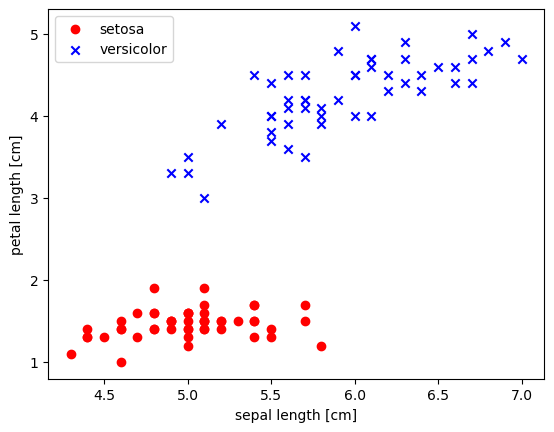

In [13]:
# 산점도 그리기
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='x', label='versicolor')

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.show()

### 퍼셉트론 모델 훈련하기

In [19]:
ppn = Perceptron(eta=0.1, n_iter=10)

ppn.fit(X, y) #학습

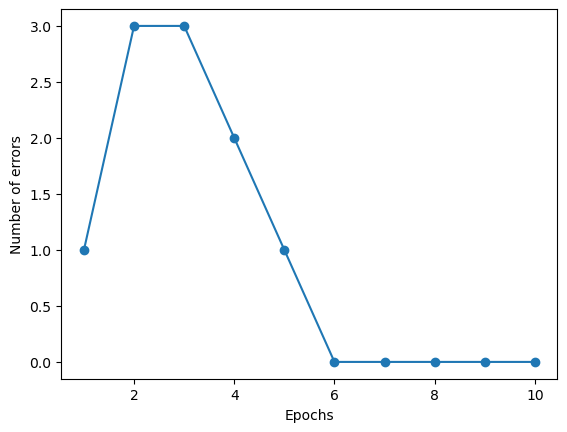

In [20]:
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o') #x;len(ppn.errors_) + 1(에포크) / y; ppn.errors_(잘못 분류한 갯수)
plt.xlabel('Epochs')
plt.ylabel('Number of errors')
plt.show()

### 결정 경계 그래프 함수

In [21]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # 마커와 컬러맵을 설정
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 결정 경계 그림
    #1. 두 특성의 min, max값 구함  
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1 
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    #2. 범위에 따른 그리드 생성
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),np.arange(x2_min, x2_max, resolution))
    #3. 레이블 z예측
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 샘플의 산점도 그림
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

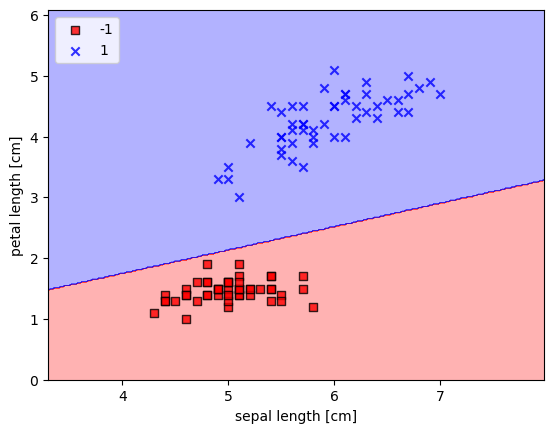

In [22]:
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.show()

# 2) 적응형 선형 뉴런(아달린)과 학습의 수렴

## 2-1) 파이썬으로 아달린 구현하기

In [23]:
#적응형 선형 뉴런 분류기 (ADALINE) + (배치) 경사하강법 ( batch gradient desent)
class AdalineGD(object):
    """
    매개변수: eta/ n_iter/ random_state
    -----------
    속성: w_ / cost_ 
    (퍼셉트론과 차이) cost_ : list ; 에포크마다 누적된 비용 함수의 제곱합

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

#train data 학습
    def fit(self, X, y):
        """
        매개변수: X/ y
        ----------
        반환값: self
        """
        #1. 가중치 작은 값으로 초기화
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        #2.(퍼셉트론과 차이) 각 train data : x에 대해 출력값 계산, 가중치 업뎃
        for i in range(self.n_iter):
            # 2-1) 입->출력값 계산
            net_input = self.net_input(X)
            output = self.activation(net_input)
            # 2-2) 가중치, 비용함수 계산
            errors = (y - output) 
            self.w_[1:] += self.eta * X.T.dot(errors) #1~m까지의 가중치
            self.w_[0] += self.eta * errors.sum() #절편
            cost = (errors**2).sum() / 2.0 # 비용 = 2/1 Σ(y-y')^2
            #2-3)비용 기록
            self.cost_.append(cost) 
        return self

#입력
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

#(퍼셉트론과 차이) 선형 활성화 계산
    def activation(self, X): #항등함수이므로 코드 영향x (단일층 신경망을 통한 정보 이동 표현)
        return X

# 클레스 레이블 예측-> 단위 계단 함수 사용
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

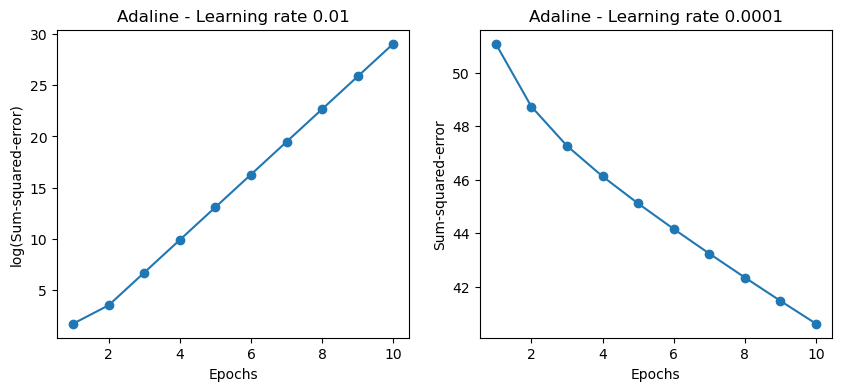

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

#1. 학습률 너무 커서 발산
ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) + 1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

#2. 정상적으로 수렴
ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) + 1), ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_title('Adaline - Learning rate 0.0001')

plt.show()

## 2-2) 특성 스케일을 조정하여 경사 하강법 결과 향상

In [26]:
# 특성을 표준화합니다.
# x표준화= x - 평균 / 표준편차
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

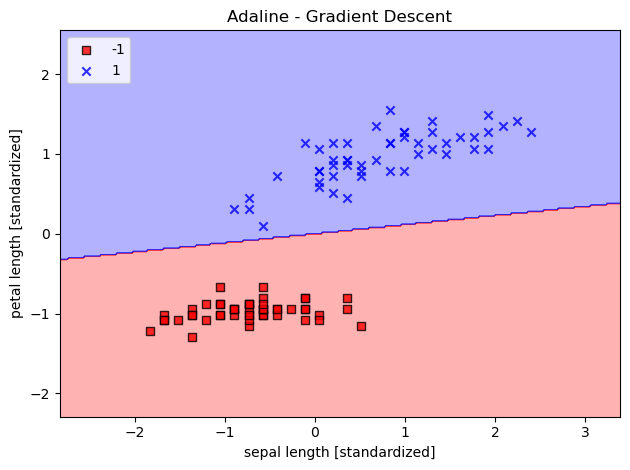

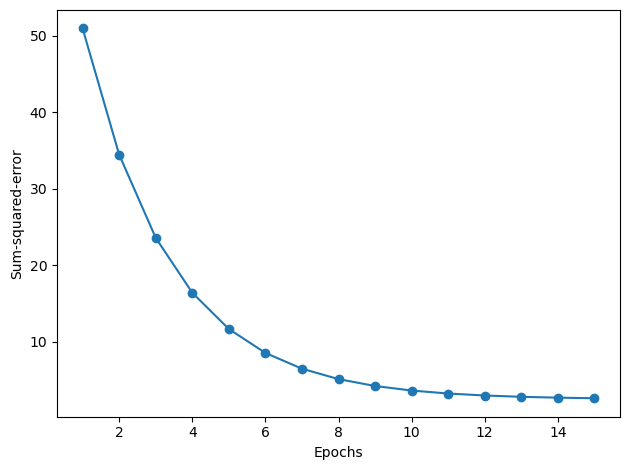

In [28]:
#아달린 학습
ada = AdalineGD(n_iter=15, eta=0.01)
ada.fit(X_std, y)

#결정경계 그래프
plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

#수렴과정 그래프
plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.tight_layout()
plt.show()

## 2-3)대규모 머신 러닝과 확률적 경사 하강법

In [13]:
#적응형 선형 뉴런 분류기 (ADALINE) + 확률적 경사하강법 (stochastic gradient desent)
class AdalineSGD(object):
    """
    매개변수: eta/ n_iter/ random_state
    (배치 경사하강법과 차이) shuffle : bool (default: True)
      True로 설정하면 같은 반복이 되지 않도록 에포크마다 훈련 데이터를 섞는다
    -----------
    속성: w_ / cost_ 
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state

#train data 학습        
    def fit(self, X, y):
        """
        매개변수: X/ y
        ----------
        반환값: self
        """
        #1. 가중치 작은 값으로 초기화
        self._initialize_weights(X.shape[1])
        self.cost_ = []

        #2.(배치 경사 하강법과 차이) 각 train data : x에 대해 출력값 계산, 가중치 업뎃
        for i in range(self.n_iter):
            #2-1) 데이터 섞음
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            
            #2-2) 섞은 데이터로 가중치 업뎃
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            #2-3) 평균 비용 기록
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

#온라인 학습 : 가중치를 초기화 하지 않고 입력되는 train 데이터 학습
    def partial_fit(self, X, y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

#---------------------------
#train 데이터 섞음
    def _shuffle(self, X, y):
        r = self.rgen.permutation(len(y))
        return X[r], y[r]

#가중치 초기화 함수
    def _initialize_weights(self, m):
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True

#아달린으로 가중치 업데이트
    def _update_weights(self, xi, target):
        # 1) 입->출력값 계산
        output = self.activation(self.net_input(xi))
        error = (target - output)
        # 2) 가중치, 비용함수 계산
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2 # 비용 = 2/1(y-y')^2
        return cost

#입력
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

#선형 활성화 계산
    def activation(self, X):
        return X

# 클레스 레이블 예측-> 단위 계단 함수 사용
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

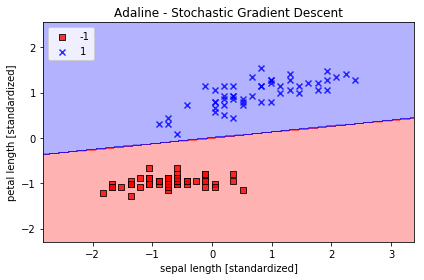

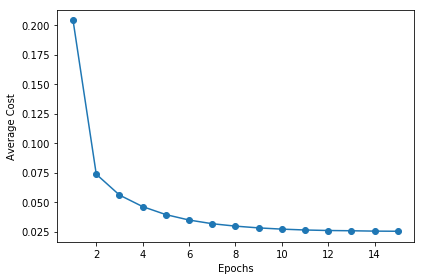

In [14]:
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada.fit(X_std, y)

#결정경계
plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

#수렴
plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')
plt.tight_layout()
plt.show()